In [32]:
!pip install face_recognition -q

ライブラリのインストール

In [97]:
!pip install face_recognition -q
!git clone https://github.com/opencv/opencv 
!pip install realeyes_nel_sdk/dist/native_emotions_library*.tar.gz
!pip install fer
!pip install plotly

jupyterのextensionの設定

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter nbextension install --py plotlywidget --user
# !jupyter nbextension enable plotlywidget --user --py

In [1]:
%matplotlib inline
import face_recognition
from fer import FER, Video
import matplotlib
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image, ImageFont
from IPython.display import display
import cv2
import numpy as np
font = {"family": "TakaoGothic"}
matplotlib.rc('font', **font)

# 画像を読み込む。
img = face_recognition.load_image_file("face.jpeg")

Instructions for updating:
non-resource variables are not supported in the long term


### fer library

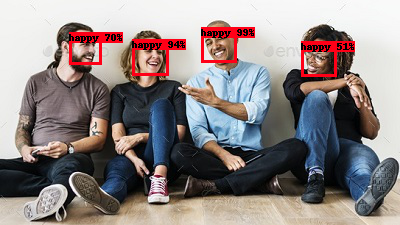

In [4]:
def draw_boxes(img):
    detector = FER(mtcnn=True)
    detection = detector.detect_emotions(img)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img, mode="RGBA")

    # 色の一覧を作成する。
    cmap = plt.cm.get_cmap("hsv",  1)

    # フォントを作成する。
    fontsize = max(15, int(0.03 * min(img.size)))
    font = ImageFont.load_default()

    for bbox in detection:
        # 色を取得する。
        color = cmap(0, bytes=True)

        # ラベル
        caption = f"happy {round(bbox['emotions']['happy']*100)}%"
        top, left, bottom, right = bbox['box']

        # 矩形を描画する。
        draw.rectangle(
            (top, left, top+bottom, right+left), outline=color, width=3
        )

        # ラベルを描画する。
        text_h, text_w = draw.textsize(caption, font=font)
        text_x2 = left + text_w - 1
        text_y2 = top + text_h - 1

        draw.rectangle((top, left, text_y2, text_x2), fill=color)
        draw.text((top, left), caption, fill="black", font=font)
    
    return img
img = plt.imread("face.jpeg")
draw_boxes(img)

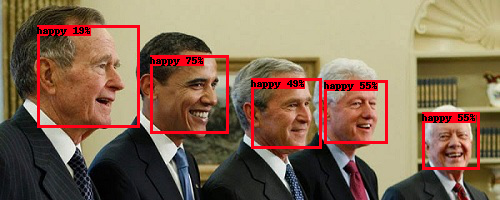

In [5]:
img = plt.imread("face2.jpeg")
draw_boxes(img)

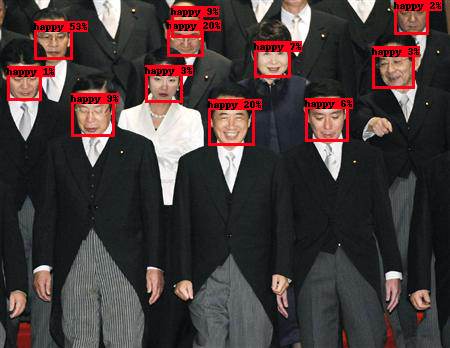

In [6]:
img = plt.imread("face3.jpeg")
draw_boxes(img)

### ビデオ分析

In [35]:
video_filename = "./東海オンエア.mov"
video = Video(video_filename)
# Analyze video, displaying the output
detector = FER(mtcnn=True)
video.analyze(detector, display=True)

![video_analysis](./video_analysis.png)

In [46]:
cap = cv2.VideoCapture("./東海オンエア.mov")
detector = FER(mtcnn=True)
scores = []
for i in range(50):
    for j in range(50):
        ret, img = cap.read()
    if img is None:
        break
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imsave(f'save/{i}.png', img)
    detection = detector.detect_emotions(img)
    score = 0
    for bbox in detection:
        score += bbox['emotions']['happy']/len(detection)
    scores.append(score)

　時系列でプロットしてみる

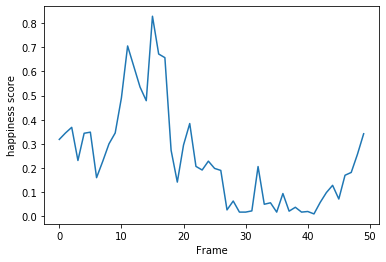

In [39]:
plt.plot(np.array(scores))
plt.xlabel('Frame')
plt.ylabel('happiness score')
plt.show()

<IPython.core.display.Javascript object>


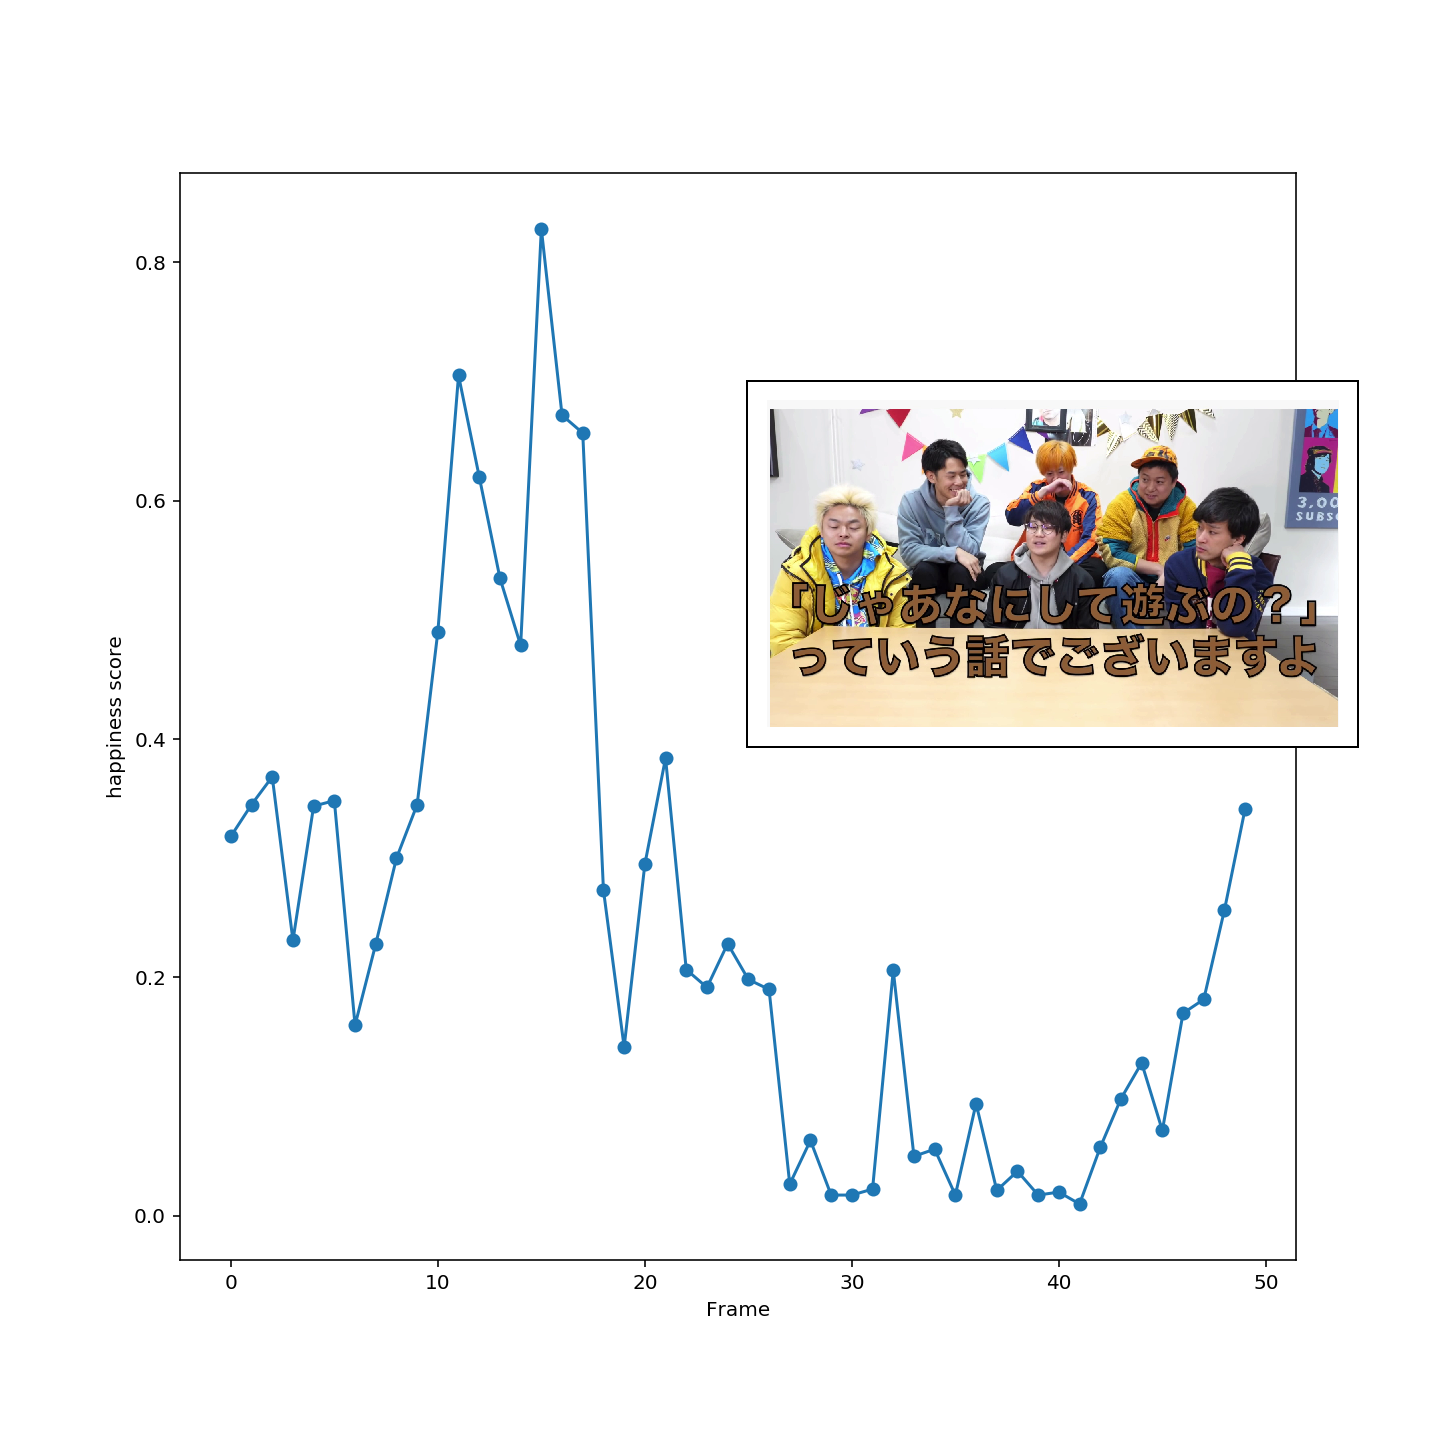

In [126]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib notebook
width = 28
nskip = 35
fig, ax = plt.subplots(figsize=(10.0, 10.0))
cmap = plt.cm.RdYlGn
img = plt.imread(f'./save/0.png')
imagebox = OffsetImage(img, zoom=0.2)
imagebox.image.axes = ax
annot = AnnotationBbox(imagebox, xy=(len(scores)*3//4, 0.5), xybox=(width,width),
                xycoords="data", boxcoords="offset points", pad=1,
                arrowprops=dict( arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
annot.set_visible(True)
ax.add_artist(annot)
sc = plt.scatter(xs, n_scores)
plt.xlabel('Frame')
plt.ylabel('happiness score')
plt.plot(xs, n_scores)

def update_annot(ind):
    i = ind["ind"][0]
    pos = sc.get_offsets()[i]
#     annot.xy = (pos[0], pos[1])
# 定点
    annot.xy = (len(scores)*3//4, 0.5)
    img = plt.imread(f'./save/{i}.png')
    imagebox.set_data(img)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        annot.set_visible(True)
        fig.canvas.draw_idle()
        cont, ind = sc.contains(event)
        update_annot(ind)

fig.canvas.mpl_connect("button_press_event", hover)

plt.show()

- 音のモデル
- ヒートマップ
- プロットと動画の位置合わせ

### 顔検出してみる

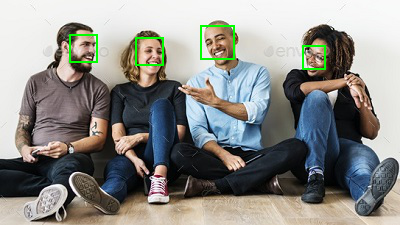

In [2]:
# 画像から顔の領域を検出する。
face_locs = face_recognition.face_locations(img, model="cnn", number_of_times_to_upsample=2)

def draw_faces(img, locs):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img, mode="RGBA")

    for top, right, bottom, left in locs:
        draw.rectangle((left, top, right, bottom), outline="lime", width=2)

    display(img)


draw_faces(img, face_locs)

### 画像から顔を切り抜いて笑顔を検出し、定量化してみる

In [3]:
# capture = cv2.VideoCapture(0)
# capture.set(3,640)# 320 320 640 720
# capture.set(4,480)#180 240  360 405

face_cascade = cv2.CascadeClassifier('opencv/data/haarcascades/haarcascade_frontalface_default.xml')
smile_cascade = cv2.CascadeClassifier('opencv/data/haarcascades/haarcascade_smile.xml')
img = face_recognition.load_image_file("face.jpeg")

# 動画用
# while True:
# img = cv2.imread('face.jpeg')
# ret, img = capture.read()
# img = cv2.flip(img,1)#鏡表示にするため．

def show_laghness_score(img):
    face_locs = face_recognition.face_locations(img, model="cnn", number_of_times_to_upsample=2)
    draw_faces(img, face_locs)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(10,10))
    score = 0
    for ( top, right, bottom, left) in face_locs:
    # for x,y,w,h in faces:
        x,y,w,h=left,top, (right-left), (bottom-top)
    #     cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2) # blue
        #Gray画像から，顔領域を切り出す．
    #     roi_gray = gray[y:y+h, x:x+w] 
        roi_gray = gray[top:bottom, left:right] 

        #サイズを縮小
        roi_gray = cv2.resize(roi_gray,(100,100))

         # 輝度で規格化
        lmin = roi_gray.min() #輝度の最小値
        lmax = roi_gray.max() #輝度の最大値
        for index1, item1 in enumerate(roi_gray):
            for index2, item2 in enumerate(item1) :
                roi_gray[index1][index2] = int((item2 - lmin) / (lmax-lmin) * item2)
        #cv2.imshow("roi_gray2",roi_gray)  #輝度を正規化した画像を表示

        smiles= smile_cascade.detectMultiScale(roi_gray, scaleFactor= 1.1, minNeighbors=1, minSize=(20, 20))#笑顔識別
        if len(smiles) >0 : # 笑顔領域がなければ以下の処理を飛ばす．#if len(smiles) <=0 : continue でもよい．その場合以下はインデント不要
            # サイズを考慮した笑顔認識
            smile_neighbors = len(smiles)
            #print("smile_neighbors=",smile_neighbors) #確認のため認識した近傍矩形数を出力
            LV = 1/30
            intensityZeroOne = smile_neighbors  * LV 
            if intensityZeroOne > 1.0: intensityZeroOne = 1.0
            score += intensityZeroOne/len(face_locs)
            #print(intensityZeroOne) #確認のため強度を出力
            for(sx,sy,sw,sh) in smiles:
                cv2.circle(img,(int(x+(sx+sw/2)*w/100),int(y+(sy+sh/2)*h/100)),int(sw/2*w/100), (255*(1.0-intensityZeroOne), 0, 255*intensityZeroOne),2)#red
    plt.imshow(img)
    plt.show()
    return round(score,2)

# plt.imshow(img)
# cv2.imshow('img.png',img)
# plt.imshow(img)
# key Operation
# key=cv2.waitKey(5) 
# if key ==27 or key ==ord('q'): #escまたはeキーで終了
#     break
# capture.release()
# cv2.destroyAllWindows()
# print("Exit") 

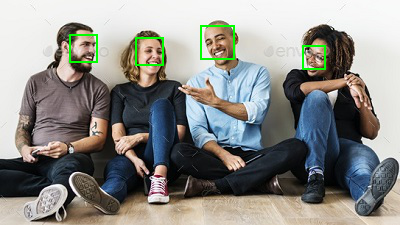

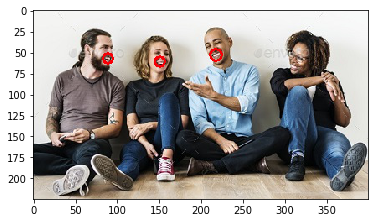

In [4]:
img = face_recognition.load_image_file("face.jpeg")
score = show_laghness_score(img)
# print(f"score: {score}")

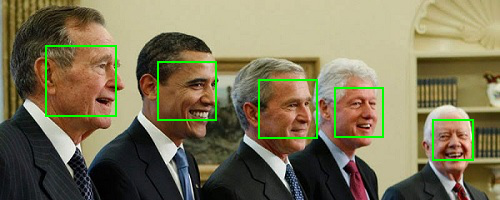

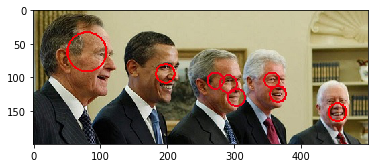

In [5]:
img = face_recognition.load_image_file("face2.jpeg")
score = show_laghness_score(img)
# print(f"score: {score}")

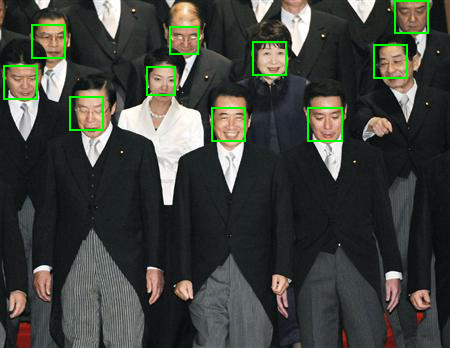

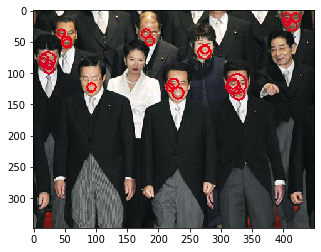

In [6]:
img = face_recognition.load_image_file("face3.jpeg")
score = show_laghness_score(img)
# print(f"score: {score}")

メモ：横顔とか下を向いていたりするとdetectうまくいっていなさそう

顔の各部位の検出

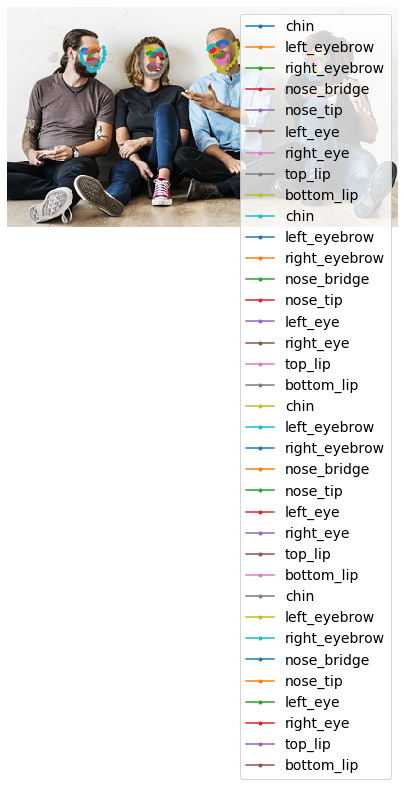

In [4]:
# 画像から顔の領域を検出する。
face_locs = face_recognition.face_locations(img, model="cnn", number_of_times_to_upsample=2)

# 顔の各部位を検出する。
facial_landmarks = face_recognition.face_landmarks(img, face_locs)
#pprint(facial_landmarks)

# 日本語訳
jp_names = {'nose_bridge': '鼻筋',
            'nose_tip': '鼻先',
            'top_lip': '上唇',
            'bottom_lip': '下唇',
            'left_eye': '左目',
            'right_eye': '左目',
            'left_eyebrow': '左眉毛',
            'right_eyebrow': '右眉毛',
            'chin': '下顎'}

# 可視化する。
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img)
ax.set_axis_off()
for face in facial_landmarks:
    for name, points in face.items():
        points = np.array(points)
        ax.plot(points[:, 0], points[:, 1], 'o-', ms=3, label=name)
ax.legend(fontsize=14)

plt.show()

<!-- Appendix インタラクションプロット試行錯誤 -->

Appendix; インタラクションプロット試行錯誤

In [127]:
# plotly
import plotly.graph_objects as go
n_scores=np.array(scores)
xs = np.array(range(len(scores)))
fig = go.Figure(data=[
    go.Scatter(x=xs, y=n_scores, name="sin", hovertemplate =
    '<i>Price</i>: $%{y:.2f}'+
    '<br><b>X</b>: %{x}<br>'),
])
fig.show()

In [ ]:
# 動画コマ送り
from ipywidgets import Play, IntSlider, jslink, HBox, interactive_output
import time

def f(k):
    html = HTML(f"<img src='./save/{k}.png'>")
    display(html)

play = Play(value=0, min=0, max=len(n_scores)-1, step=1, interval=1500, description="Press play",)
slider = IntSlider(min=0, max=len(n_scores)-1)
jslink((play, 'value'), (slider, 'value'))
fig = go.FigureWidget()
fig.add_scatter(y=n_scores);
ui = HBox([play, slider])
out = interactive_output(f, {'k': slider})
display(ui, out)

In [129]:
# plotly*ipywidgets
# ref:
# https://gist.github.com/raphaeljolivet/f076256e589f67c028a6bffaab279601
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
# https://qiita.com/studio_haneya/items/adbaa01b637e7e699e75
# https://plotly.com/python/hover-text-and-formatting/
# https://plotly.com/python/line-and-scatter/
# https://dash.plotly.com/interactive-graphing
# https://plotly.com/python/ipython-notebook-tutorial/

from ipywidgets import HTML, VBox
from plotly import graph_objects as go
import pandas as pd
import plotly.express as px
from IPython.display import display

def interactive_plot(fig, template, event="hover") :
    """
    Make a plot react on hover or click of a data point and update a HTML preview below it.
    **template** Should be a string and contain placeholders like {colname} to be replaced by the value
    of the corresponding data row.
    
    """

    html = HTML("<p>0</p>")

    def update(trace, points, state):
        idx = points.point_inds[0]
        html.value = template.format(x=idx)

    fig = go.FigureWidget(data=fig.data, layout=fig.layout)

    if event == "hover" :
        fig.data[0].on_hover(update)
    else :
        fig.data[0].on_click(update)
    fig.show()
    
    def fn(fig):
        fig.show()

    return VBox([fig, html]), interactive_output(fn, {'fig': fig})

n_scores=np.array(scores)
xs = np.array(range(len(n_scores)))
df=pd.DataFrame({'x': xs, "y": n_scores})
plot=px.scatter(df, x='x', y='y') 
template="<img src='./save/{x}.png'>"
box,fn = interactive_plot(plot, template)
display(box,fn)